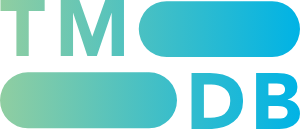

# IMDb Movies: Analysis & Predictions

## Business Problem:
For this project, you have been hired to produce a MySQL database on Movies from a subset of IMDB's publicly available dataset. Ultimately, you will use this database to analyze what makes a movie successful and will provide recommendations to the stakeholder on how to make a successful movie.

### Source:  
#### https://datasets.imdbws.com/ .gz

We will focus on the following data files: <br> 
**title.basics.tsv.gz** <br>
**title.ratings.tsv.gz** <br>
**title.akas.tsv.gz** <br>

In [1]:
# !pip install tmdbsimple

### Part 2: Financial Data    
***
#### Use an API to **extract box office revenue and profit data** to add to your IMDB data and **perform exploratory data analysis**.

**Specifications - Financial Data**

Your stakeholder would like you to extract and save the results for movies that meet all of the criteria established in part 1 of the project (You should already have a filtered dataframe saved from part one as a csv.gz file)

As a proof-of-concept, they requested you perform a test extraction of movies that started in 2000 or 201

Each year should be saved as a separate .csv.gz **file**

Hint: Use the two custom functions from the lessons (Intro to TMDB API, and Efficient TMDB API r-  code!

One function will add the certification (MPGG Rating) to m- ovie.info
The other function will help you append/extend a JSON file with Python
Confirm Your API Function works.

In order to ensure your function for extracting movie data from TMDB is working, test your function on these 2 movie ids: tt0848228 ("The Avengers") and tt0332280 ("The Notebook"). Make sure that your function runs without error and that it returns the correct movie's data for boSve etrieved and saved the final results to 2 sepallowing questions.

- #### **Financial Data**
> Your stakeholder wants you to extract the budget, revenue, and MPAA Rating (G/PG/PG-13/R), which is also called "Certification"

#### **1. Imports**

In [2]:
import pandas as pd

import os, time,json
import tmdbsimple as tmdb 
from tqdm.notebook import tqdm_notebook

import matplotlib.pyplot as plt

FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['akas.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'final_tmdb_data_2002.csv.gz',
 'ratings.csv.gz',
 'title_basics.csv.gz',
 'tmdb_api_results_2001.json',
 'tmdb_api_results_2002.json']

- #### **Functions**

In [3]:
def get_movie_with_rating(movie_id):
        movie = tmdb.Movies(movie_id)
        info = movie.info()
        
        release = movie.releases()
        for c in release['countries']:
            if c['iso_3166_1'] == 'US':
                info['certification'] = c['certification']

        return info

In [4]:
def write_json(new_data, filename): 
    """Appends a list of records (new_data) to a json file (filename). 
    Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""  
    
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

- #### **Using Your API Credentials**

In [5]:
with open('/Users/Erfoxcroft/.secret/tmdb_api.json', 'r') as f:

    login = json.load(f)

tmdb.API_KEY =  login['api-key']

- #### **Confirm Your API Function works**

In [6]:
# Testing our function by looping through a list of ids

test_ids = ["tt0848228", "tt0332280"]  
results = []
errors = []
for movie_id in test_ids:
    
    try:
        movie_info = get_movie_with_rating(movie_id)
        results.append(movie_info)
        
    except Exception as e: 
        errors.append([movie_id, e])
    
pd.DataFrame(results)
pd.DataFrame(errors)

print(f"- Number of successfull retrievals: {len(results)}")
print(f"- Number of errors: {len(errors)}")

- Number of successfull retrievals: 2
- Number of errors: 0


- #### **Load in the Title Basics data**

In [7]:
# Load in the dataframe from project part 1 as basics:
basics = pd.read_csv(f'{FOLDER}title_basics.csv.gz')

In [8]:
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
3,tt0082328,movie,Embodiment of Evil,Encarnação do Demônio,0,2008.0,NaN,94,Horror
4,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"


- #### **Create Required Lists for the Loop**

In [9]:
YEARS_TO_GET = [2001,2002]

In [10]:
# Organize output by year into separate .json files using an OUTER LOOP
# Start of OUTER loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    # Defining the JSON file to store results for the year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    
    # Check if the file exists
    file_exists = os.path.isfile(JSON_FILE)
    
    # If it does not exist: create it
    if not file_exists:  # Simplified condition
        # Save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE, 'w') as f:
            json.dump([{'imdb_id': 0}], f)

    # Saving the new year as the current df
    df = basics.loc[basics['startYear'] == YEAR].copy()
    # Saving movie ids to list
    movie_ids = df['tconst'].copy()

    # Load existing data from json into a dataframe called "previous_df"
    previous_df = pd.read_json(JSON_FILE)

    # Filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]

    # Get index and movie id from the list
    # INNER Loop
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                  desc=f'Movies from {YEAR}',
                                  position=1,
                                  leave=True):
        try:
            # Retrieve the data for the movie id
            temp = get_movie_with_rating(movie_id)
            # Append/extend results to the existing file using a pre-made function
            write_json(temp, JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming the server
            time.sleep(0.02)

        except Exception as e:
            errors.append([movie_id, e])

    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)

print(f"- Total errors: {len(errors)}")

YEARS:   0%|          | 0/2 [00:00<?, ?it/s]

Movies from 2001:   0%|          | 0/1584 [00:00<?, ?it/s]

Movies from 2002:   0%|          | 0/1584 [00:00<?, ?it/s]

- Total errors: 503
